# **MaldiAMRKit** quick guide

If you haven't installed the package yet, run this:
```bash
pip install maldiamrkit
```

### Import `maldiamrkit`

In [1]:
from maldiamrkit.spectrum import MaldiSpectrum
from maldiamrkit.dataset import MaldiSet
from maldiamrkit.preprocessing import PreprocessingSettings
from maldiamrkit.peak_detector import MaldiPeakDetector
from maldiamrkit.warping import Warping

Other imported packages

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

### Visualize `PreprocessingSettings` default parameters 

In [3]:
default_cfg = PreprocessingSettings()
default_cfg.as_dict()

{'trim_from': 2000,
 'trim_to': 20000,
 'savgol_window': 20,
 'savgol_poly': 2,
 'baseline_half_window': 40}

### `MaldiSpectrum` preprocessing and plot

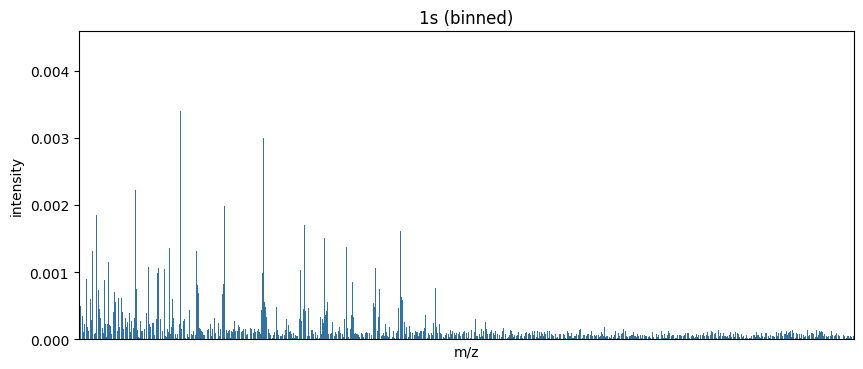

In [4]:
# smoothing, baseline removal, normalisation
spec = MaldiSpectrum(
    "../data/1s.txt"
).preprocess()
# [optional] bin width 3 Da
spec.bin(3)
# plot
_ = spec.plot(binned=True)

Eventually you can activate messages

In [5]:
spec = MaldiSpectrum(
    "../data/1s.txt",
    verbose=True
).preprocess()
spec.bin(3).binned

INFO: Preprocessed spectrum 1s
INFO: Binned spectrum 1s (w=3)


,mass,intensity
0,2000,0.000039
1,2003,0.000041
2,2006,0.000083
3,2009,0.000123
4,2012,0.000109
...,...,...
5995,19985,0.000087
5996,19988,0.000054
5997,19991,0.000048
5998,19994,0.000050


Skipping binning

INFO: Preprocessed spectrum 1s


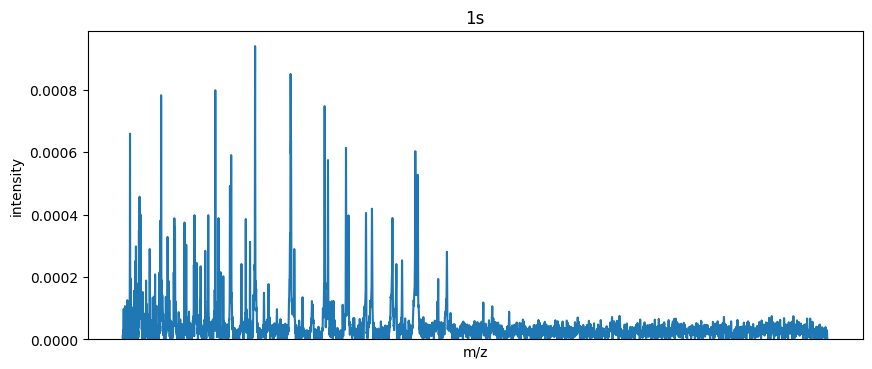

In [6]:
spec = MaldiSpectrum(
    "../data/1s.txt",
    verbose=True
).preprocess()
_ = spec.plot(binned=False)

### Build the `MaldiSet` dataset from a directory containing raw spectra

In [7]:
data = MaldiSet.from_directory(
    "../data/",
    "../data/metadata/metadata.csv",
    aggregate_by=dict(antibiotics="Drug"),
)
X, y = data.X, data.y

X.shape, y.shape

((29, 6000), (29, 1))

In [8]:
y.head()

,Drug
22s,R
6s,S
28s,S
5s,S
19s,S


Plot pseudogel visualization

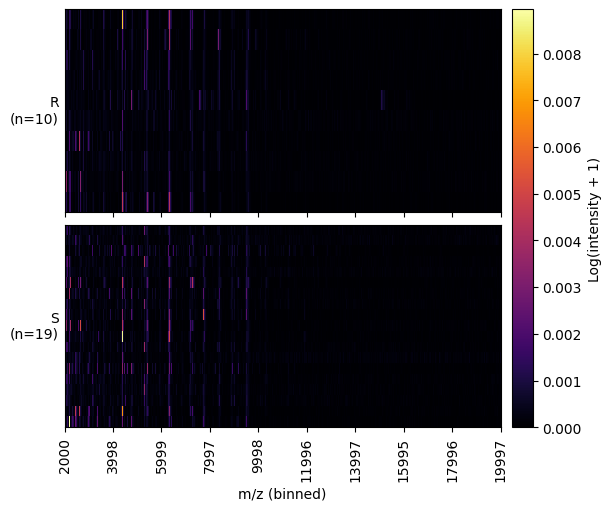

In [9]:
_ = data.plot_pseudogel()

Map Resistant (and intermediate) strains to 1, susceptible strains to 0

In [10]:
y = y["Drug"].map({
    "S": 0,
    "I": 1,
    "R": 1
})
y.head()

22s    1
6s     0
28s    0
5s     0
19s    0
Name: Drug, dtype: int64

### Use of `MaldiPeakDetector` within a *scikit-learn* `Pipeline`

In [11]:
pipe = Pipeline([
    ("peaks", MaldiPeakDetector(binary=False, prominence=1e-7)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

pipe.fit(X, y)
pipe.score(X, y)

1.0

### Use of `Warping` within a *scikit-learn* `Pipeline`

Method: `shift`

In [12]:
pipe = Pipeline([
    ("warp", Warping(method="shift")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

pipe.fit(X, y)
pipe.score(X, y)

1.0

Method: `linear`

In [13]:
pipe = Pipeline([
    ("warp", Warping(method="linear")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

pipe.fit(X, y)
pipe.score(X, y)

1.0

Method: `piecewise`

In [14]:
pipe = Pipeline([
    ("warp", Warping(method="piecewise", n_segments=600)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

pipe.fit(X, y)
pipe.score(X, y)

1.0

Method: `dtw`

In [15]:
pipe = Pipeline([
    ("warp", Warping(method="dtw")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

pipe.fit(X, y)
pipe.score(X, y)

1.0

Example of alignment

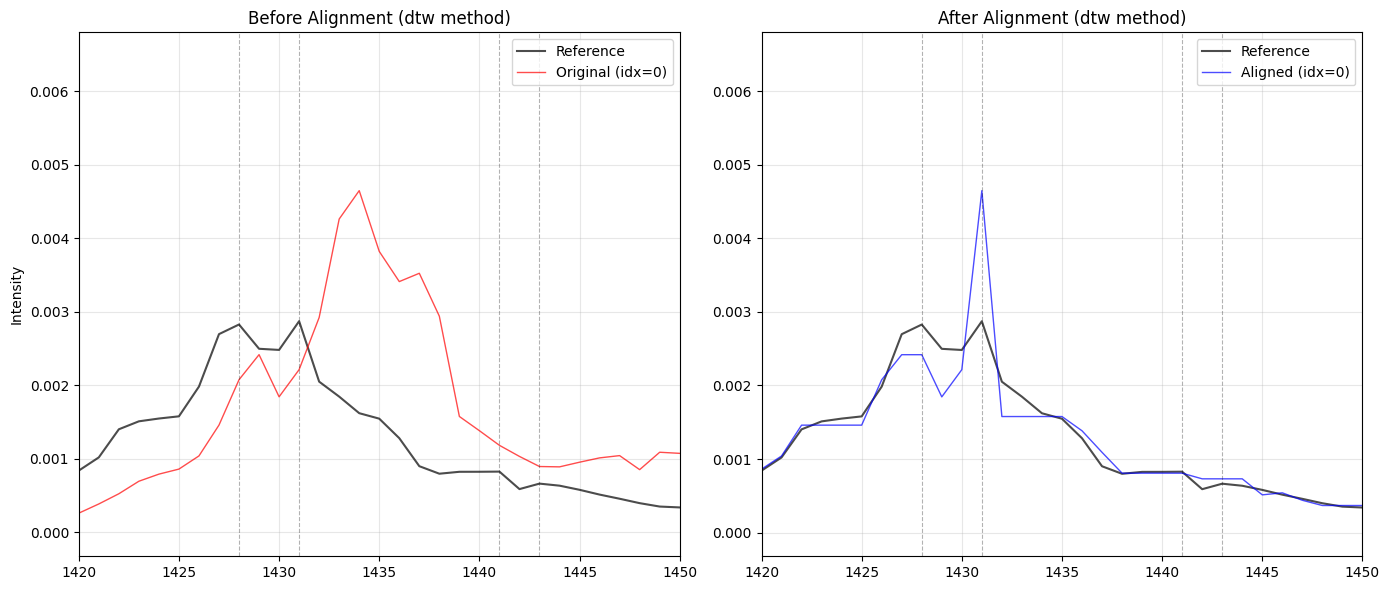

In [16]:
_ = pipe.steps[0][1].plot_alignment(
    X,
    indices=[0],
    xlim=(1420, 1450)
)